In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error 
import datetime
import sys
import seaborn as sns
import statsmodels
import statsmodels.stats.diagnostic as diag
from statsmodels.tsa.stattools import adfuller
from scipy.stats.mstats import normaltest
from matplotlib.pyplot import acorr
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# importing data
df = pd.read_csv('Dataset\\data_stocks.csv')

In [3]:
# converting timestamp to datetime
df["DATE"] = pd.to_datetime(df["DATE"], unit = 's')

# setting date as index
df.set_index("DATE", drop = True, inplace = True)

# downsampling to days and forward filling missing days
df = df.resample('D', label = 'right', closed = 'right').ffill()

# first 5 rows
df.head()

,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,NASDAQ.AMAT,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
DATE,,,,,,,,,,,,,,,,,,,,,
2017-04-04,2358.9600,42.48,143.700,129.62,81.22,101.27,85.39,58.10,119.28,38.89,...,84.01,118.11,44.39,39.39,82.08,7.25,49.43,63.55,121.35,53.175
2017-04-05,2359.9600,40.90,144.770,130.04,81.24,101.45,84.95,59.30,118.30,39.00,...,84.18,119.92,44.50,39.71,82.34,7.22,50.36,63.84,120.78,52.640
2017-04-06,2352.8401,41.31,144.020,129.89,80.04,101.93,83.54,58.80,116.21,38.38,...,84.34,117.65,44.81,39.37,82.53,7.15,50.41,63.87,120.17,52.670
2017-04-07,2357.6699,41.72,143.685,130.15,80.32,101.75,84.07,58.73,115.49,38.59,...,85.17,118.14,44.60,39.80,83.02,7.13,50.93,64.56,120.22,52.680
2017-04-08,2355.6899,41.81,143.340,130.22,80.01,102.19,84.79,58.10,115.62,38.93,...,84.69,118.22,44.40,39.82,82.78,7.13,50.84,64.28,119.88,52.550


In [4]:
# dimensions of the dataset
df.shape

(151, 501)

We have to pick up the following stocks and generate forecasts accordingly.

1. NASDAQ.AAPL
2. NASDAQ.ADP
3. NASDAQ.CBOE
4. NASDAQ.CSCO
5. NASDAQ.EBAY

### NASDAQ.AAPL

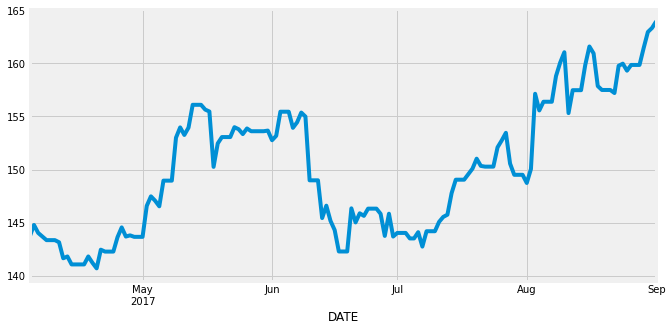

In [5]:
# visualising the stock price
AAPL = pd.DataFrame(df["NASDAQ.AAPL"])
AAPL.columns = ["Price"]
AAPL["Price"].plot(figsize = [10,5])

In [6]:
# H0: It is non stationary
# H1: It is stationary

def adfuller_test(data):
    result = adfuller(data)
    labels = ["ADF Test Statistic", "p-value", "Lags Used", "Number of Observations Used"]
    for value, label in zip(result, labels):
        print(label,":",str(value))
    if result[1]<=0.05:
        print("Reject Null Hypothesis. Data is Stationary")
    else:
        print("Accept Null Hypothesis. Data is not Stationary")

In [7]:
adfuller_test(AAPL)

ADF Test Statistic : -0.8435342689914025
p-value : 0.8059986620186446
Lags Used : 0
Number of Observations Used : 150
Accept Null Hypothesis. Data is not Stationary


In [8]:
# performing differencing to remove seasonality and trends
AAPL["First Difference"] = AAPL - AAPL.shift(1)

In [9]:
adfuller_test(AAPL["First Difference"].dropna())

ADF Test Statistic : -13.250795021728953
p-value : 8.78444515646589e-25
Lags Used : 0
Number of Observations Used : 149
Reject Null Hypothesis. Data is Stationary


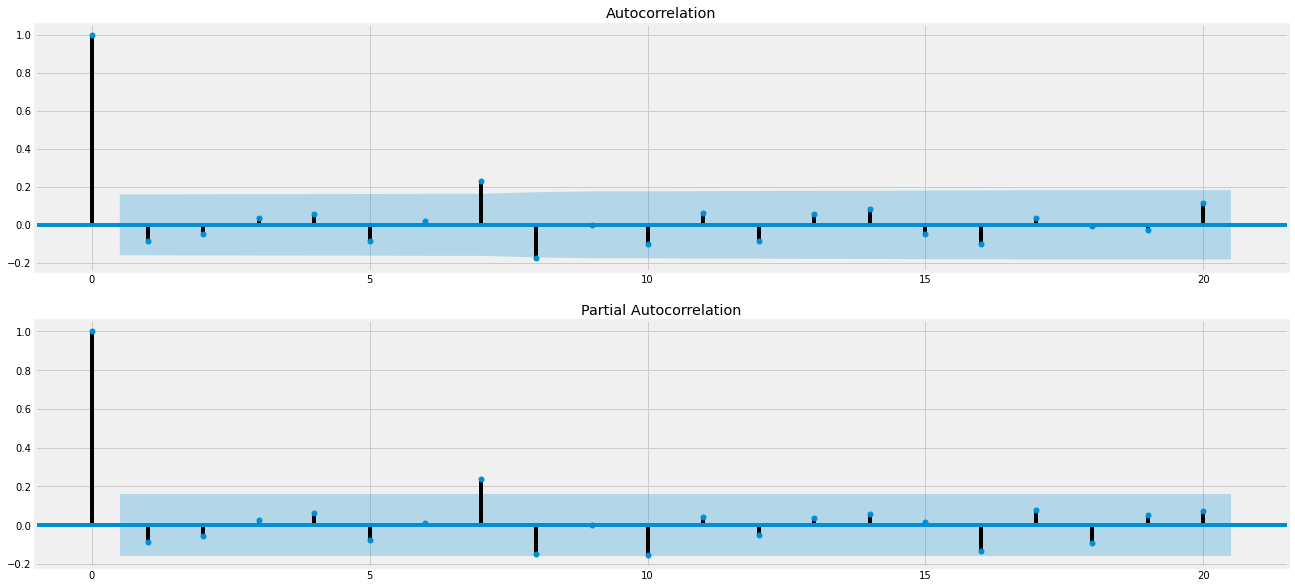

In [10]:
# plotting acf and pacf
fig = plt.figure(figsize=[20,10])
ax1 = fig.add_subplot(211)
fig = plot_acf(AAPL['First Difference'].iloc[1:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(AAPL['First Difference'].iloc[1:], lags=20, ax=ax2)

In [11]:
# fitting the model with p=1, d=0, q=1
model = ARIMA(AAPL["Price"][0:120], order = (1,0,1))
model_fit = model.fit()

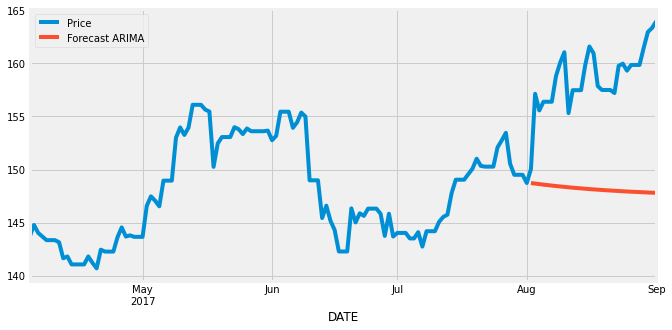

In [12]:
# plotting future forecasts against actual price
AAPL["Forecast ARIMA"] = model_fit.predict(start=120, end=151)
AAPL[["Price", "Forecast ARIMA"]].plot(figsize=[10,5])

In [13]:
# fitting seasonal arima
model = SARIMAX(AAPL["Price"][0:120], order = (1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()

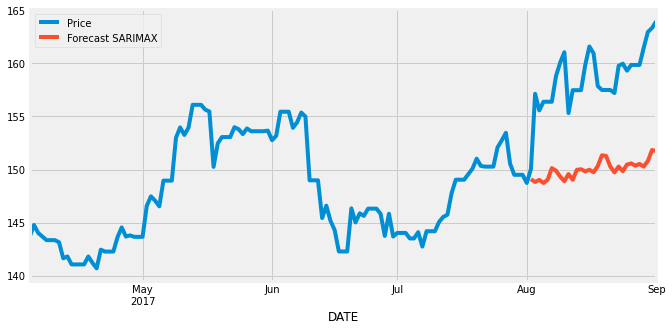

In [14]:
# plotting future forecasts against actual price
AAPL["Forecast SARIMAX"] = model_fit.predict(start=120, end=151)
AAPL[["Price", "Forecast SARIMAX"]].plot(figsize=[10,5])

### NASDAQ.ADP

In [15]:
ADP = pd.DataFrame(df["NASDAQ.ADP"])
ADP.columns = ["Price"]

In [16]:
adfuller_test(ADP)

ADF Test Statistic : -2.184296668442446
p-value : 0.21199414536326167
Lags Used : 1
Number of Observations Used : 149
Accept Null Hypothesis. Data is not Stationary


In [17]:
# performing differencing to remove seasonality and trends
ADP["First Difference"] = ADP - ADP.shift(1)

adfuller_test(ADP["First Difference"].dropna())

ADF Test Statistic : -10.929621321461358
p-value : 9.898927763431438e-20
Lags Used : 0
Number of Observations Used : 149
Reject Null Hypothesis. Data is Stationary


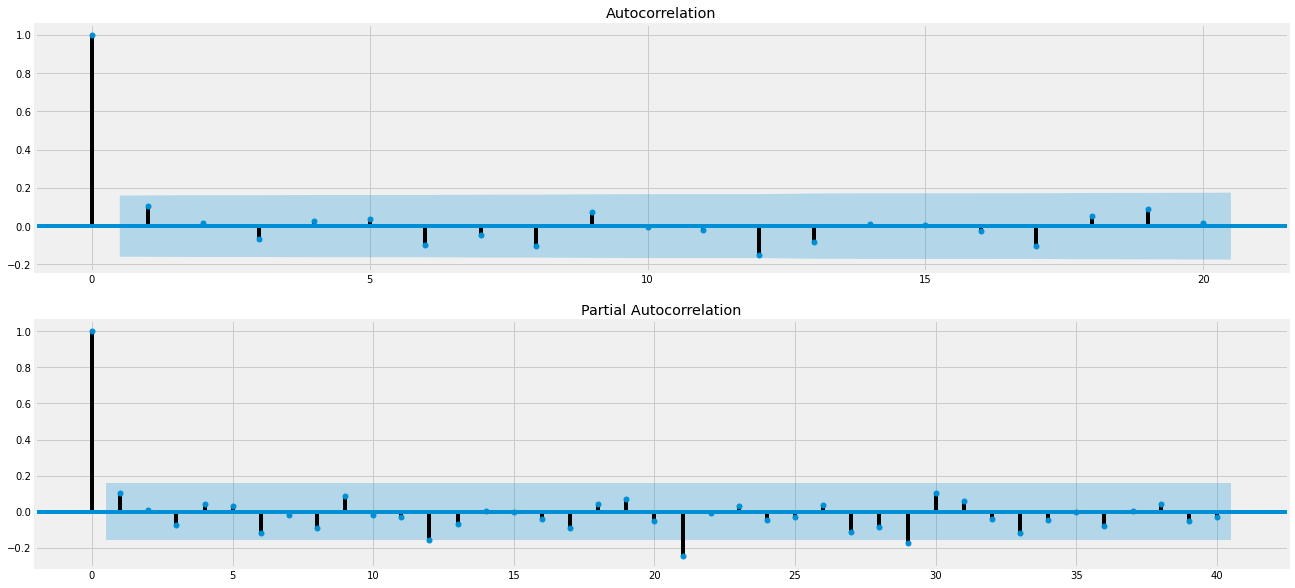

In [18]:
# plotting acf and pacf
fig = plt.figure(figsize=[20,10])
ax1 = fig.add_subplot(211)
fig = plot_acf(ADP['First Difference'].iloc[1:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(ADP['First Difference'].iloc[1:], lags=40, ax=ax2)

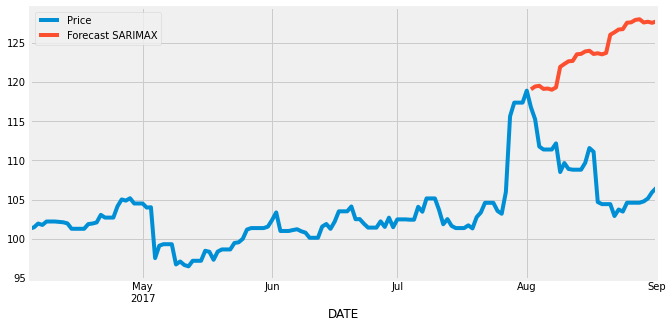

In [19]:
# fitting the model
model = SARIMAX(ADP["Price"][0:120], order = (1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()

# plotting future forecasts against actual price
ADP["Forecast SARIMAX"] = model_fit.predict(start=120, end=151)
ADP[["Price", "Forecast SARIMAX"]].plot(figsize=[10,5])

### NASDAQ.CBOE

In [20]:
CBOE = pd.DataFrame(df["NASDAQ.CBOE"])
CBOE.columns = ["Price"]

In [21]:
adfuller_test(CBOE)

ADF Test Statistic : 0.32541270276981643
p-value : 0.9784808317370641
Lags Used : 1
Number of Observations Used : 149
Accept Null Hypothesis. Data is not Stationary


In [22]:
# performing differencing to remove seasonality and trends
CBOE["First Difference"] = CBOE - CBOE.shift(1)

adfuller_test(CBOE["First Difference"].dropna())

ADF Test Statistic : -13.980188923888948
p-value : 4.191096952216783e-26
Lags Used : 0
Number of Observations Used : 149
Reject Null Hypothesis. Data is Stationary


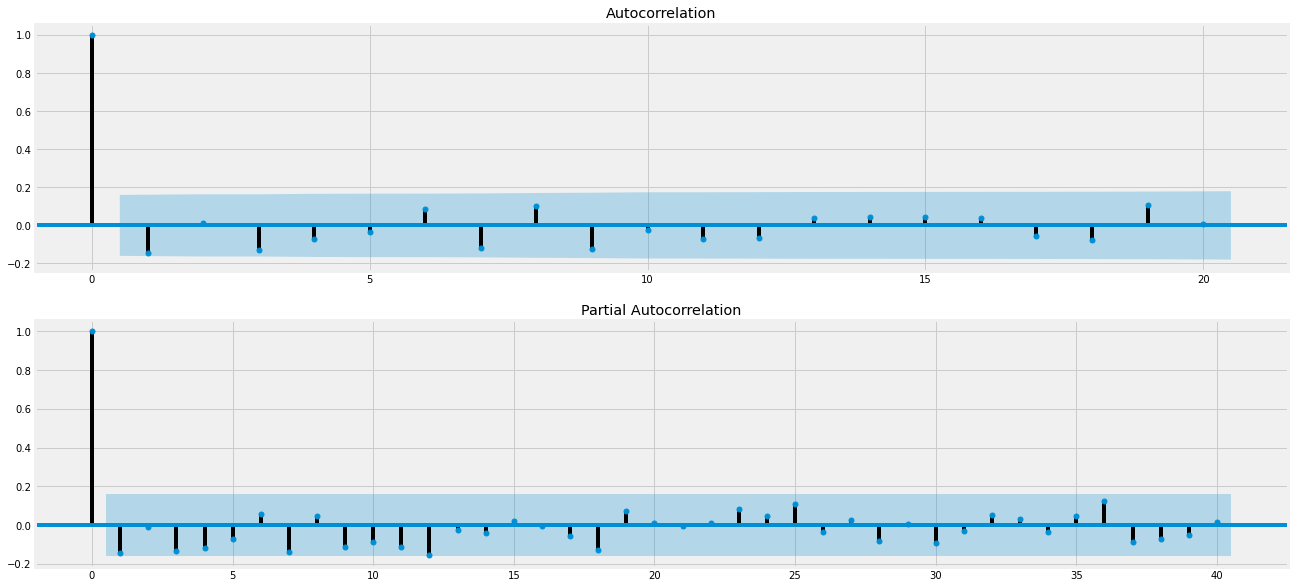

In [23]:
# plotting acf and pacf
fig = plt.figure(figsize=[20,10])
ax1 = fig.add_subplot(211)
fig = plot_acf(CBOE['First Difference'].iloc[1:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(CBOE['First Difference'].iloc[1:], lags=40, ax=ax2)

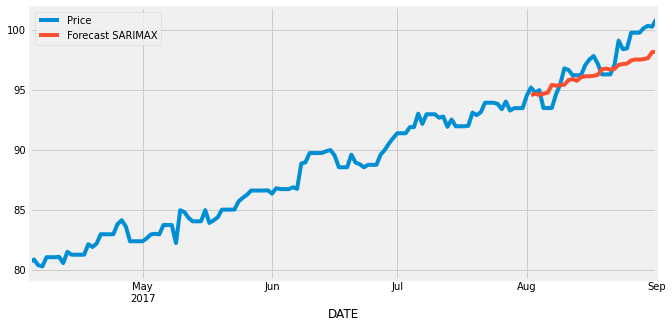

In [24]:
# fitting the model
model = SARIMAX(CBOE["Price"][0:120], order = (1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()

# plotting future forecasts against actual price
CBOE["Forecast SARIMAX"] = model_fit.predict(start=120, end=151)
CBOE[["Price", "Forecast SARIMAX"]].plot(figsize=[10,5])

### NASDAQ.CSCO

In [25]:
CSCO = pd.DataFrame(df["NASDAQ.CSCO"])
CSCO.columns = ["Price"]

In [26]:
adfuller_test(CSCO)

ADF Test Statistic : -2.468548472670508
p-value : 0.12331553839359827
Lags Used : 1
Number of Observations Used : 149
Accept Null Hypothesis. Data is not Stationary


In [27]:
# performing differencing to remove seasonality and trends
CSCO["First Difference"] = CSCO - CSCO.shift(1)

adfuller_test(CSCO["First Difference"].dropna())

ADF Test Statistic : -10.641869846949708
p-value : 4.906411570944911e-19
Lags Used : 0
Number of Observations Used : 149
Reject Null Hypothesis. Data is Stationary


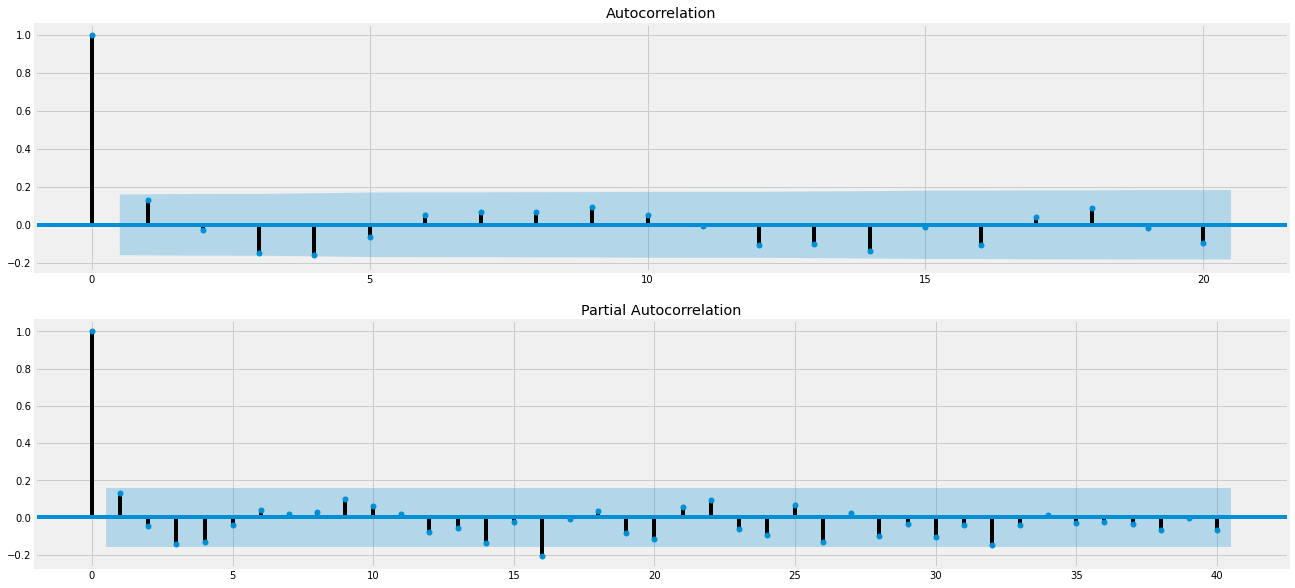

In [28]:
# plotting acf and pacf
fig = plt.figure(figsize=[20,10])
ax1 = fig.add_subplot(211)
fig = plot_acf(CSCO['First Difference'].iloc[1:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(CSCO['First Difference'].iloc[1:], lags=40, ax=ax2)

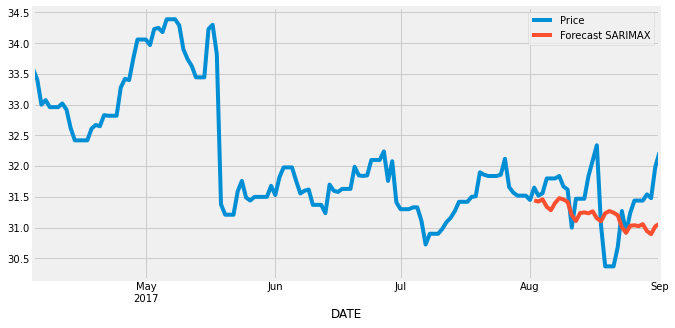

In [29]:
# fitting the model
model = SARIMAX(CSCO["Price"][0:120], order = (1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()

# plotting future forecasts against actual price
CSCO["Forecast SARIMAX"] = model_fit.predict(start=120, end=151)
CSCO[["Price", "Forecast SARIMAX"]].plot(figsize=[10,5])

### NASDAQ.EBAY

In [30]:
EBAY = pd.DataFrame(df["NASDAQ.EBAY"])
EBAY.columns = ["Price"]

In [31]:
adfuller_test(EBAY)

ADF Test Statistic : -1.9909073437213223
p-value : 0.2905740881701623
Lags Used : 0
Number of Observations Used : 150
Accept Null Hypothesis. Data is not Stationary


In [32]:
# performing differencing to remove seasonality and trends
EBAY["First Difference"] = EBAY - EBAY.shift(1)

adfuller_test(EBAY["First Difference"].dropna())

ADF Test Statistic : -12.59004632216882
p-value : 1.8296459621324423e-23
Lags Used : 0
Number of Observations Used : 149
Reject Null Hypothesis. Data is Stationary


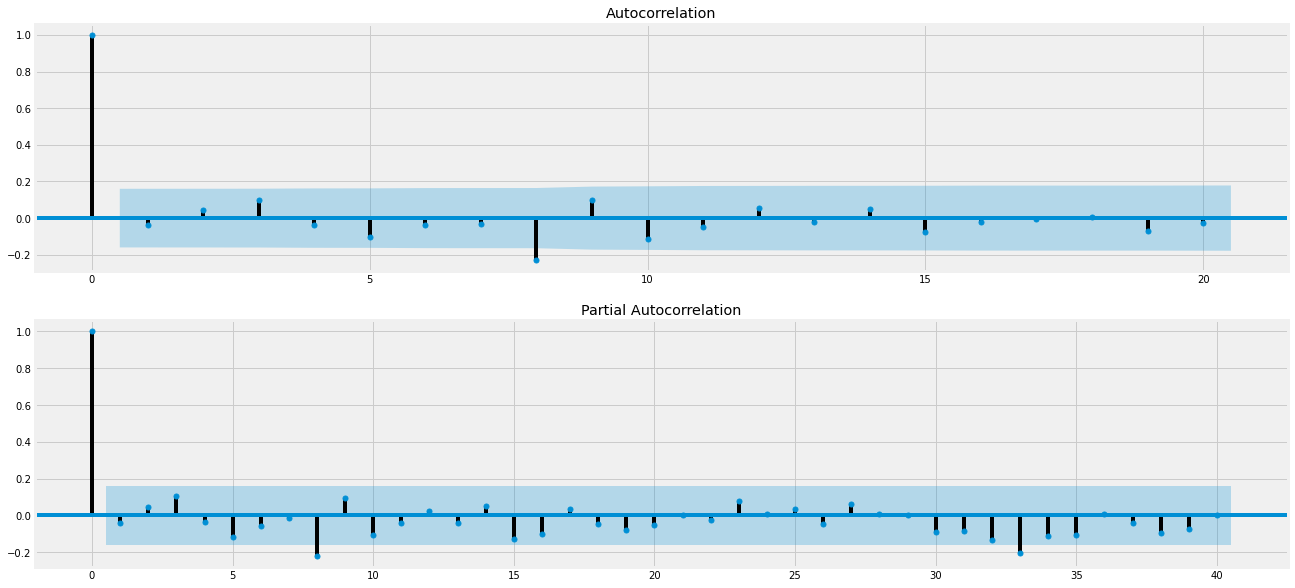

In [33]:
# plotting acf and pacf
fig = plt.figure(figsize=[20,10])
ax1 = fig.add_subplot(211)
fig = plot_acf(EBAY['First Difference'].iloc[1:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(EBAY['First Difference'].iloc[1:], lags=40, ax=ax2)

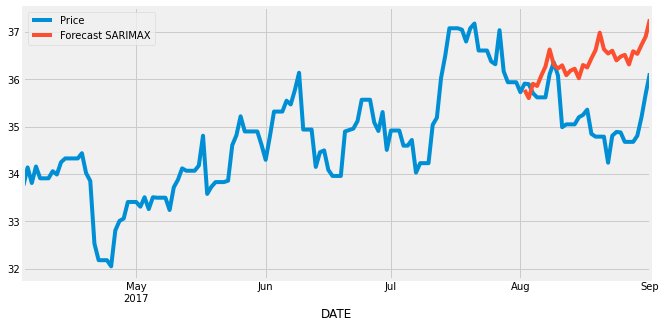

In [34]:
# fitting the model
model = SARIMAX(EBAY["Price"][0:120], order = (1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()

# plotting future forecasts against actual price
EBAY["Forecast SARIMAX"] = model_fit.predict(start=120, end=151)
EBAY[["Price", "Forecast SARIMAX"]].plot(figsize=[10,5])

In [39]:
print("The MSE for AAPL using SARIMAX is",mean_squared_error(AAPL['Price'][120:], AAPL['Forecast SARIMAX'][120:]))
print("The MSE for ADP using SARIMAX is",mean_squared_error(ADP['Price'][120:], ADP['Forecast SARIMAX'][120:]))
print("The MSE for CBOE using SARIMAX is",mean_squared_error(CBOE['Price'][120:], CBOE['Forecast SARIMAX'][120:]))
print("The MSE for CSCO using SARIMAX is",mean_squared_error(CSCO['Price'][120:], CSCO['Forecast SARIMAX'][120:]))
print("The MSE for EBAY using SARIMAX is",mean_squared_error(EBAY['Price'][120:], EBAY['Forecast SARIMAX'][120:]))

The MSE for AAPL using SARIMAX is 81.22385432929953
The MSE for ADP using SARIMAX is 299.6569126788589
The MSE for CBOE using SARIMAX is 2.129227261339037
The MSE for CSCO using SARIMAX is 0.31700380596961547
The MSE for EBAY using SARIMAX is 1.758745259991395
